In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import datetime as dt

DATAPATH = './models/'
# GPU training
DEVICE = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
#DEVICE = torch.device('cpu')
print(f"Training on device {DEVICE}.")
torch.cuda.memory_allocated()

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on device cuda.


0

In [5]:
from cocoBox import load_coco_dataset

BATCH_SIZE = 1
IMG_SIZE = 300
# Select image categories with which to train SSD
#categories = ('horse', 'bird', 'cat', 'dog', 'person', 'car')
categories = (('dog', 'cat', 'bird', 'horse'))
train_dataloader, valid_dataloader = load_coco_dataset(batch_size=BATCH_SIZE,
                                                       size=5,
                                                       dim=IMG_SIZE,
                                                       cats=categories,
                                                       fetch_type='union')

loading annotations into memory...
Done (t=16.68s)
creating index...
index created!
Categories: {18: 0, 17: 1}
Dataset size: 5
loading annotations into memory...
Done (t=16.88s)
creating index...
index created!
Categories: {18: 0, 17: 1}
Dataset size: 5
Dataset with augmentation size: 10


In [25]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, valid_loader, max_patience=float('Inf')):
    best_valid_loss = float('Inf')
    patience = max_patience
    print('{} starting training'.format(dt.datetime.now()))
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for images, targets in train_loader:
            images = torch.cat(list(map(lambda x: x.unsqueeze(0), images))).to(device=DEVICE)
            boxes = tuple(map(lambda x: torch.tensor(x['boxes']).to(device=DEVICE), targets))
            labels = tuple(map(lambda x: torch.tensor(x['labels']).to(device=DEVICE), targets))
            coords, conf = model(images)
            loss = loss_fn(coords, conf, boxes, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        torch.cuda.empty_cache()
        # Validation
        with torch.no_grad():
            valid_loss = 0.0
            for images, targets in train_loader:
                images = torch.cat(list(map(lambda x: x.unsqueeze(0), images))).to(device=DEVICE)
                boxes = tuple(map(lambda x: torch.tensor(x['boxes']).to(device=DEVICE), targets))
                labels = tuple(map(lambda x: torch.tensor(x['labels']).to(device=DEVICE), targets))
                coords, conf = model(images)
                loss = loss_fn(coords, conf, boxes, labels)
                valid_loss += loss.item()
        torch.cuda.empty_cache()
        # Verbose training
        train_loss = train_loss / len(train_loader)
        valid_loss = valid_loss / len(valid_loader)
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Train {:.5f}, Valid {:.5f}'.format(dt.datetime.now(),
                                                                      epoch,
                                                                      train_loss,
                                                                      valid_loss))
        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), DATAPATH + 'ssd.pt')
            print(f'Saving {epoch}-th for {valid_loss = :2.5f}')
            best_valid_loss = valid_loss
            patience = max_patience
        elif patience == 0:
            return
        else:
            patience = patience - 1


In [ ]:
import importlib
import VGG16_theirs
importlib.reload(VGG16_theirs)
import SSD
importlib.reload(SSD)
import utils
importlib.reload(utils)
import SSDLoss
importlib.reload(SSDLoss)
from SSD import SSDmodel
from SSDLoss import SSDLoss

ssd = SSDmodel(class_num=len(categories)).to(device=DEVICE)
adam = torch.optim.SGD(ssd.parameters(), lr=1e-3, weight_decay=0.0005, momentum=0.9)
ssd_loss = SSDLoss(device=DEVICE)
training_loop(n_epochs=160000,
              optimizer=adam,
              loss_fn=ssd_loss,
              model=ssd,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)


Loaded base model.



<Figure size 1200x6000 with 0 Axes>

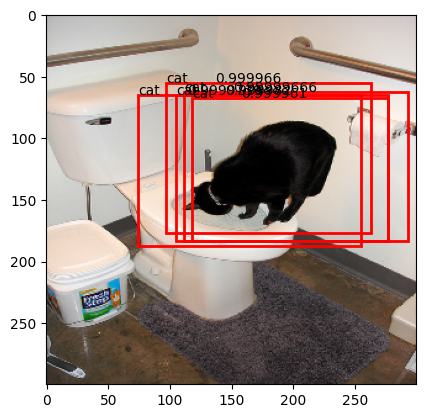

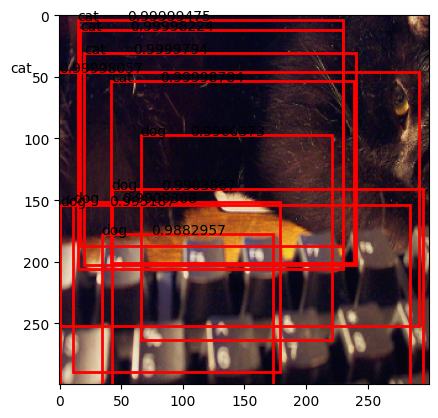

In [86]:
import importlib
import matplotlib.pyplot as plt
import SSD
importlib.reload(SSD)
from SSD import SSDmodel
from matplotlib import patches

# Load best models
ssd = SSDmodel(class_num=len(categories)).to(device=DEVICE)
ssd.load_state_dict(torch.load(DATAPATH + 'ssdSmall.pt', map_location=DEVICE))
plt.figure(figsize=(12, 60))
for imgs, targets in valid_dataloader:
    imgs = torch.cat(list(map(lambda x: x.unsqueeze(0), imgs))).to(device=DEVICE)
    boxes = tuple(map(lambda x: torch.tensor(x['boxes']).to(device=DEVICE), targets))
    labels = tuple(map(lambda x: torch.tensor(x['labels']).to(device=DEVICE), targets))
    fig, ax = plt.subplots()
    img = imgs[0]
    target = targets[0]
    ax.imshow(img.permute(1, 2, 0).cpu(), vmin=0, vmax=1)
    """
    for idx, box in enumerate(target['boxes']):
        width = box[2] * img.shape[2]
        height = box[3] * img.shape[1]
        x = box[0] * img.shape[2] - width/2
        y = box[1] * img.shape[1] - height/2
        print(f'{box * 300 = }')
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor="b", fill=False)
        ax.add_patch(rect)
        ax.text(x=x, y=y, s=categories[np.argwhere(target['labels'][idx])[0][0]])
        ax.text(x=x-15, y=y, s="GT")
    """
    with torch.no_grad():
        offs, conf, labels = ssd.predict(imgs)
    pred_img = offs[0].cpu()
    pred_conf = conf[0].cpu()
    pred_label = labels[0].cpu()
    for idx, box in enumerate(pred_img):
        if pred_conf[idx, 0] < 0.9:
            continue
        width = box[2] * img.shape[2]
        height = box[3] * img.shape[1]
        x = box[0] * img.shape[2] - width/2
        y = box[1] * img.shape[1] - height/2
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor="r", fill=False)
        ax.add_patch(rect)
        ax.text(x=x, y=y, s=categories[pred_label[idx, 0]])
        ax.text(x=x+40, y=y, s=pred_conf[idx, 0].numpy())
    plt.show()
